In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import pytide
import utm
import seaborn as sns
from sklearn.linear_model import LinearRegression
dir = './FES2014-PCP'

In [2]:
archivos = os.listdir(os.path.join(dir, 'ocean_tide_extrapolated_PCP'))

# Verificar que la lista de archivos tiene 34 elementos
print(len(archivos))

34


In [6]:
# Cargar y procesar datos de niveles
niveles = pd.read_excel('ADCP NIVELES.xlsx', usecols=['Fecha y hora local', 'Nivel del mar (m)'])
niveles['Fecha y hora local'] = pd.to_datetime(niveles['Fecha y hora local']).dt.floor('min')
niveles.set_index('Fecha y hora local', inplace=True)

# Contar el número total de NaNs en cada columna
print("Número total de NaNs en cada columna:")
print(niveles.isna().sum())

# Ver las filas específicas que contienen NaNs
print("\nFilas que contienen NaNs:")
print(niveles[niveles.isna().any(axis=1)])

Número total de NaNs en cada columna:
Nivel del mar (m)    93
dtype: int64

Filas que contienen NaNs:
                     Nivel del mar (m)
Fecha y hora local                    
2013-04-09 05:14:00                NaN
2013-04-09 05:19:00                NaN
2013-04-09 05:24:00                NaN
2013-04-09 05:29:00                NaN
2013-04-09 05:34:00                NaN
...                                ...
2013-04-09 12:34:00                NaN
2013-04-09 12:39:00                NaN
2013-04-09 12:44:00                NaN
2013-04-09 12:49:00                NaN
2013-04-09 12:54:00                NaN

[93 rows x 1 columns]


In [7]:
# Cargar y procesar datos de niveles
niveles = pd.read_excel('ADCP NIVELES.xlsx', usecols=['Fecha y hora local', 'Nivel del mar (m)'])
niveles['Fecha y hora local'] = pd.to_datetime(niveles['Fecha y hora local']).dt.floor('min')
niveles.set_index('Fecha y hora local', inplace=True)

# Ajustar huso horario
niveles.index = niveles.index + pd.Timedelta(hours=5)

# Ajustar nivel del mar
niveles['Nivel del mar (m)'] -= niveles['Nivel del mar (m)'].mean()
niveles = niveles.resample('5T').mean().interpolate()

# Verificar latitud y longitud
lat0, lon0 = utm.to_latlon(505523, 8285343, 18, northern=False)
lon0 = lon0 % 360

# Inicializar listas para nombres, fases y amplitudes
nom, fase, amp = [], [], []

# Listar y procesar archivos en el directorio
archivos = [f for f in os.listdir(os.path.join(dir, 'ocean_tide_extrapolated_PCP')) if f.endswith('.nc')]
for arch in archivos:
    datos = xr.open_dataset(os.path.join(dir, 'ocean_tide_extrapolated_PCP', arch)).sel(lon=lon0, lat=lat0, method="nearest")
    nom.append(arch[:-3])
    fase.append(datos.phase.data)
    amp.append(datos.amplitude.data)

# Crear DataFrame con los datos de constantes
constantes = pd.DataFrame(data=zip(nom, amp, fase), columns=['Name', 'amplitude', 'phase'])

# Configurar pytide
nombres = pd.read_csv('nombresFES_pytide.csv', sep=';')
wt = pytide.WaveTable(nombres.pytide)

# Calcular modulaciones nodales
fecha_min = niveles.index.min()
fecha_max = niveles.index.max().round('min')
tiempo = pd.date_range(start=fecha_min, end=fecha_max, freq='5min')
f, vu = wt.compute_nodal_modulations(tiempo.values)

def predi(tabla, facto, vum, fecha):
    H = tabla.amplitude
    K = tabla.phase
    Q = len(f)
    ondas = pd.DataFrame()
    for i in range(Q):
        ondas.insert(i, i, H[i] * facto[i, :] * np.cos(vum[i, :] - np.radians(K[i])))
    suma = ondas.sum(axis=1).values
    suma = suma / 100  # Convertir de cm a m
    prediccion = pd.DataFrame(suma, fecha, columns=['pred'])
    return ondas, prediccion

# Realizar predicción de mareas
onda, marea = predi(constantes, f, vu, tiempo.values)

# Cambiar el nombre de la columna a "Predicción de marea"
marea.columns = ['Predicción de marea']

# Asegurarse de que los índices coincidan
niveles = niveles.reindex(tiempo)

# Ajustar los datos para regresión
x = marea['Predicción de marea'].values.reshape(-1, 1)
y = niveles['Nivel del mar (m)'].values

# Realizar regresión lineal
reg = LinearRegression().fit(x, y)
y_pred = reg.predict(x)
r2 = reg.score(x, y)

print(r2)

0.956879548034853


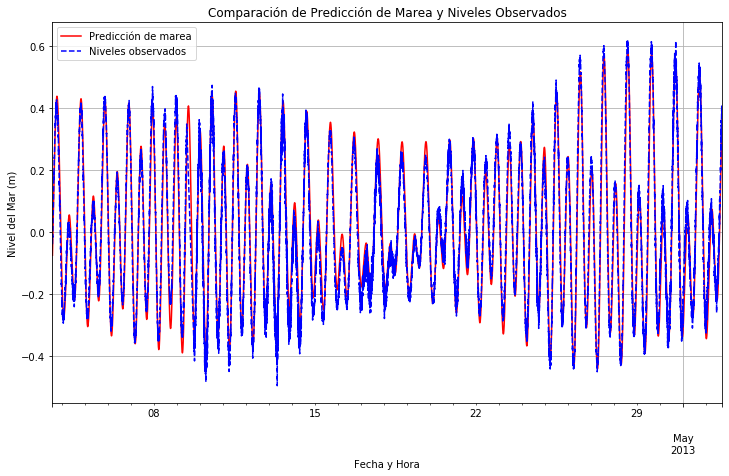

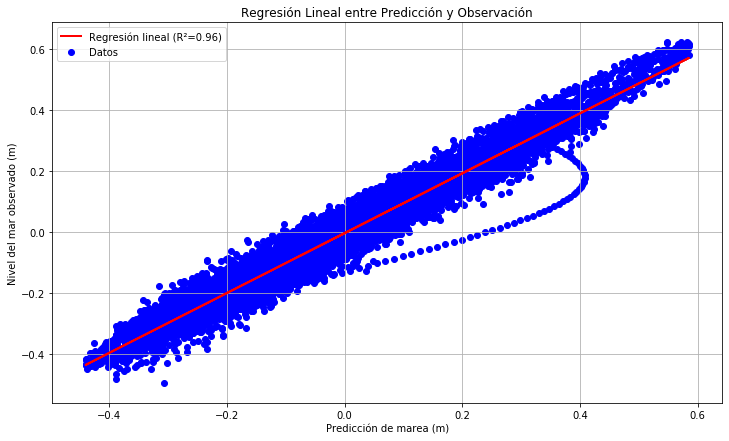

In [10]:
# Gráfico de series temporales
fig1, ax1 = plt.subplots(figsize=(12, 7))
marea.plot(ax=ax1, color='r', label='Predicción de marea con FES')
niveles['Nivel del mar (m)'].plot(ax=ax1, label='Niveles observados', style='b--')
ax1.set_title('Comparación de Predicción de Marea y Niveles Observados')
ax1.set_xlabel('Fecha y Hora')
ax1.set_ylabel('Nivel del Mar (m)')
ax1.legend()
ax1.grid()
plt.show()

# Gráfico de dispersión con línea de regresión
fig2, ax2 = plt.subplots(figsize=(12, 7))
ax2.scatter(x, y, color='blue', label='Datos')
ax2.plot(x, y_pred, color='red', linewidth=2, label=f'Regresión lineal (R²={r2:.2f})')
ax2.set_title('Regresión Lineal entre Predicción y Observación')
ax2.set_xlabel('Predicción de marea (m)')
ax2.set_ylabel('Nivel del mar observado (m)')
ax2.legend()
ax2.grid()
plt.show()
